## Reading data 

In [6]:
import sqlite3
import pandas as pd

In [7]:
db =sqlite3.connect('../Data/database.sqlite')
data= pd.read_sql_query(""" SELECT * from Reviews WHERE Score!=3 LIMIT 5000""",db) 

In [8]:
print(data.columns)
print(data.shape)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
(5000, 10)


In [9]:
score=data['Score']

In [10]:
def partition(x):
    if x < 3:
        return 0
    return 1

classified_score=score.map(partition)
data['Score'] = classified_score
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
'''all the users who have given reviews more than 1 time'''
display0 = pd.read_sql_query("""                   
SELECT UserId, ProfileName, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", db)
display0.head()

,UserId,ProfileName,COUNT(*)
0,#oc-R115TNMSPFT9I7,Breyton,2
1,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",3
2,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,2
3,#oc-R11O5J5ZVQE25C,Penguin Chick,3
4,#oc-R12KPBODL2B5ZD,Christopher P. Presta,2


In [12]:
'''all the unique users '''
display1 = pd.read_sql_query("""                   
SELECT UserId, ProfileName, COUNT(*)
FROM Reviews
GROUP BY UserId
""", db)
display1.head()

,UserId,ProfileName,COUNT(*)
0,#oc-R103C0QSV1DF5E,C,1
1,#oc-R109MU5OBBZ59U,AayGee,1
2,#oc-R10LFEMQEW6QGZ,Julie,1
3,#oc-R10LT57ZGIB140,dipr,1
4,#oc-R10UA029WVWIUI,Kim D,1


In [13]:
print(str(display0.shape[0]) + " users who gave more than 1 reviews." )
print(str(display1.shape[0])+ " unique users out of " +  str(display1['COUNT(*)'].sum()) + " reviews.")

80668 users who gave more than 1 reviews.
256059 unique users out of 568454 reviews.


# Deduplication

In [14]:
'''duplicate reviews '''

display = pd.read_sql_query(""" 
SELECT UserId, ProfileName,Time,ProductId, COUNT(*)
FROM Reviews
GROUP BY UserId, Time 
HAVING COUNT(*)>2
""", db)
display.head()



,UserId,ProfileName,Time,ProductId,COUNT(*)
0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",1342396800,B005HG9ET0,3
1,#oc-R11O5J5ZVQE25C,Penguin Chick,1346889600,B005HG9ET0,3
2,#oc-R12MGTQS5KZZRV,"SKY2110 ""SKY2110""",1344211200,B005HG9ET0,3
3,#oc-R13NNUL4EKL4FL,N. Chernyavskaya,1348358400,B005HG9ET0,3
4,#oc-R14ZSRYW2YB41B,A. Crafton,1346284800,B005HG9ET0,3


In [15]:
display.iloc[0]['UserId']

'#oc-R11D9D7SHXIJB9'

In [16]:
duplicate = pd.read_sql_query(""" 
SELECT UserId, ProfileName,Time,ProductId,Text
FROM Reviews
WHERE UserID = "#oc-R11D9D7SHXIJB9"
""", db)
duplicate.head()

,UserId,ProfileName,Time,ProductId,Text
0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",1342396800,B005HG9ESG,"My wife has recurring extreme muscle spasms, u..."
1,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",1342396800,B005HG9ERW,"My wife has recurring extreme muscle spasms, u..."
2,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",1342396800,B005HG9ET0,"My wife has recurring extreme muscle spasms, u..."


Here, the same user reviews different product Id in same time which is not possible.  While examining the productIds B005HG9ESG, B005HG9ERW, B005HG9ET0 in Amazon, we found out that they referred to same product-Essentia Water.Hence, this is a data error. 

In [17]:
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False,ignore_index=True, kind='quicksort',na_position='last')
sorted_data.shape

(5000, 10)

In [18]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [19]:
(final['Id'].size*1.0)/(data['Id'].size)*100

99.72

In [20]:
distorted_data = pd.read_sql_query(""" 
SELECT UserId, ProfileName,Time,ProductId,Text,HelpfulnessNumerator, HelpfulnessDenominator
FROM Reviews
WHERE HelpfulnessNumerator> HelpfulnessDenominator
""", db)
distorted_data

,UserId,ProfileName,Time,ProductId,Text,HelpfulnessNumerator,HelpfulnessDenominator
0,A2V0I904FH7ABY,Ram,1212883200,B001EQ55RW,It was almost a 'love at first bite' - the per...,3,2
1,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",1224892800,B000MIDROQ,My son loves spaghetti so I didn't hesitate or...,3,1


In [21]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [22]:
final.shape

(4986, 10)

# Text Preprocessing

In [23]:
import re

In [24]:
sample_0 = final['Text'].values[0]
print(sample_0)

sample_1= final['Text'].values[10]
print(sample_1)

sample_2 = final['Text'].values[11]
print(sample_2)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I bought this same brand from an online Indian grocery store that usually has excellent products.  I was able to turn it into cream/butter, using my super blender and adding some water, but it barely had any flavor.  I usually buy the Chao Kah brand of coconut cream (which is quite tasty and flavorful) and read another review for a different product for making your own coconut cream.  My complaint is not the shreds or texture.  Mine was just virtually tasteless.
I use these to keep my finicky toddler's protein levels up. What's great, is that they're delicious just about any way you can imagine cooking a sausage!<br /><br />A favorite Recipe: Sautee one large onion, about a tablespoon each dried basil and oregano, and some 

In [25]:
sample_0 = re.sub(r"http\S+", "", sample_0) #https://stackoverflow.com/a/40823105/4084039
sample_1 = re.sub(r"http\S+", "", sample_1) # remove urls from text python: 
sample_2 = re.sub(r"http\S+", "", sample_2) 


In [26]:
sample_0, sample_1, sample_2

('Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.',
 'I bought this same brand from an online Indian grocery store that usually has excellent products.  I was able to turn it into cream/butter, using my super blender and adding some water, but it barely had any flavor.  I usually buy the Chao Kah brand of coconut cream (which is quite tasty and flavorful) and read another review for a different product for making your own coconut cream.  My complaint is not the shreds or texture.  Mine was just virtually tasteless.',
 'I use these to keep my finicky toddler\'s protein levels up. What\'s great, is that they\'re delicious just about any way you can imagine cooking a sausage!<br /><br />A favorite Recipe: Sautee one large onion, about a tablespoon each dried basil and oregano, and some salt and pepper in about 2T of butter. Add sausage, tha

In [27]:
from bs4 import BeautifulSoup
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
soup0 = BeautifulSoup(sample_0, 'lxml')


soup1 = BeautifulSoup(sample_1, 'lxml')


soup2 = BeautifulSoup(sample_2, 'lxml')
soup0.text, soup1.text, soup2.text


('Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.',
 'I bought this same brand from an online Indian grocery store that usually has excellent products.  I was able to turn it into cream/butter, using my super blender and adding some water, but it barely had any flavor.  I usually buy the Chao Kah brand of coconut cream (which is quite tasty and flavorful) and read another review for a different product for making your own coconut cream.  My complaint is not the shreds or texture.  Mine was just virtually tasteless.',
 'I use these to keep my finicky toddler\'s protein levels up. What\'s great, is that they\'re delicious just about any way you can imagine cooking a sausage!A favorite Recipe: Sautee one large onion, about a tablespoon each dried basil and oregano, and some salt and pepper in about 2T of butter. Add sausage, that\'s been cut into coins

In [28]:
def decontracted(phrase):
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_2 = decontracted(soup2.text)
print(sent_2)
print("="*50)

I use these to keep my finicky toddler is protein levels up. What is great, is that they are delicious just about any way you can imagine cooking a sausage!A favorite Recipe: Sautee one large onion, about a tablespoon each dried basil and oregano, and some salt and pepper in about 2T of butter. Add sausage, that is been cut into coins, and russet potatoes cut into 1/4" thick rounds. Cover all with chicken stock and simmer until potatoes are soft but not dissolved. Throw in a few handfuls of pre-washed baby spinach (I usually use about a half a pound, and frozen would work fine, just put it in a minute earlier). Stir until the spinach is cooked, and then serve! Enjoy!


In [30]:
sent_0 = re.sub("\S*\d\S*", "", soup0.text).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here? />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [31]:
sent_0 = re.sub('[^A-Za-z0-9]+', ' ', sent_0)
print(sent_0)

Why is this when the same product is available for here The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby 


In [32]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [34]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'


stopwords= set(['the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [35]:
from tqdm import tqdm
preprocessed_reviews = []

for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2578.39it/s]


In [36]:
preprocessed_reviews[15],preprocessed_reviews[100],preprocessed_reviews[1500]

('thank goodness mexgrocer love pico pica sauce cannot find product local grocery stores anymore internet shopping makes living podunk town bearable no long lists saved occasional trip big city first name basis ups fedex drivers usps shipments hit miss fit mailbox great not saddle head town pico pica favorite product good love',
 'although seems like great product definitely not minced cans say minced not ground beef cat likes minced not chunks not ground although eat ground cat food sometimes inviting delicious yet walks away hate packaging lies contents product shipping speedy value great long deliver promise stuck food cat wont eat',
 'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes d

# Featurization

### Bag of words
- most primitive

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print( count_vect.get_feature_names()[:10])

['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']


In [38]:
print('No. of unique words in the corpus = ',len(count_vect.get_feature_names()) )

No. of unique words in the corpus =  12997


In [39]:
final_counts = count_vect.transform(preprocessed_reviews)
print('Transformed shape of the reviews ',final_counts.get_shape())

Transformed shape of the reviews  (4986, 12997)


### n-Grams

In [40]:
#ngram_range=(1,2) makes unigram and bigrams
#min_df=10, it ignore all the words whose document frequency is less than 10
#max_features=5000, build a vocabulary that only consider the top 5000 features based on document frequency
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect.fit(preprocessed_reviews)
print(count_vect.get_feature_names()[:10])
len(count_vect.get_feature_names())


['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']


3136

In [41]:
final_ngram_counts = count_vect.transform(preprocessed_reviews)

print('Transformed shape of the reviews ',final_ngram_counts.get_shape())
print("No. of unique words including both unigrams and bigrams ", final_ngram_counts.get_shape()[1])

Transformed shape of the reviews  (4986, 3136)
No. of unique words including both unigrams and bigrams  3136


### TF-IDF

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some unique words in the corpus",tf_idf_vect.get_feature_names()[0:10])
print("No. of unique words ",len(tf_idf_vect.get_feature_names()) )

some unique words in the corpus ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
No. of unique words  3136


### Word2Vec
- best for featurization of words 
- deep learning based technique, state of art

In [44]:
i=0
list_of_sentence=[]
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())

In [45]:
from gensim.models import Word2Vec

#training from the data corpse
w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print(w2v_model.wv.most_similar('worst'))

[('excellent', 0.9964052438735962), ('overall', 0.9950978755950928), ('especially', 0.9950581789016724), ('amazing', 0.9949620962142944), ('think', 0.994940459728241), ('anything', 0.9948310256004333), ('certainly', 0.9948068261146545), ('fantastic', 0.9946520924568176), ('decent', 0.994638204574585), ('missing', 0.9946020245552063)]
[('experience', 0.9993118643760681), ('stash', 0.9992848634719849), ('opinion', 0.999283492565155), ('kind', 0.9992634654045105), ('varieties', 0.9992591738700867), ('looks', 0.9992371797561646), ('yes', 0.9992362856864929), ('choice', 0.9992349743843079), ('candies', 0.9992179274559021), ('provides', 0.9992164969444275)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [46]:
w2v_words = list(w2v_model.wv.vocab)
len(w2v_words),w2v_words[:10]

(3817,
 ['product',
  'available',
  'course',
  'total',
  'pretty',
  'stinky',
  'right',
  'nearby',
  'used',
  'ca'])

In [47]:
w2v_model.wv['play']  #gives word embedding if the word is present in the vocabulary
                      # doesn't gove result for the  word ='hero'

array([-0.25989193, -0.09808164,  0.12387366, -0.10022382, -0.01637704,
       -0.08743824, -0.22258346, -0.1098413 ,  0.47456637, -0.14572722,
       -0.03649822, -0.32371902,  0.24774805, -0.25842443,  0.02903451,
       -0.1538299 ,  0.00755489,  0.2096721 , -0.08711423, -0.32394108,
       -0.29852918,  0.1184188 ,  0.1561531 ,  0.09942054,  0.22128399,
        0.0603071 ,  0.37517396, -0.30275443,  0.01597682, -0.08330914,
        0.02438149,  0.01621526, -0.36376843, -0.03131573, -0.08284258,
        0.04640486, -0.17352572,  0.6332339 ,  0.56060433,  0.17602092,
       -0.34621584, -0.10539543, -0.19884378,  0.14891571, -0.33827236,
        0.21596794, -0.22772104, -0.09617656, -0.11770812, -0.06374934],
      dtype=float32)

In [48]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## Converting  text into vectors

#### Average word2vec

In [49]:
import numpy as np 

In [50]:
avg_w2v =[]
for sentence in  tqdm(list_of_sentence):
    emb_vec = np.zeros(50) #the words are 50 dim-vectors
    count=0
    for word in sentence:
        if word in w2v_words:
            vec= w2v_model.wv[word]
            emb_vec += vec 
            count+=1
    if (count!=0): emb_vec/=count
    avg_w2v.append(emb_vec)

100%|██████████| 4986/4986 [00:05<00:00, 945.23it/s] 


In [58]:
print(len(avg_w2v),len(avg_w2v[0]))

4986 50


#### TF-IDF weighted word2vec

In [59]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [60]:
words_tf_weight = dict(zip(model.get_feature_names(),list(model.idf_))) #words as the key and the idf as value 

In [61]:
tfidf_w2v =[]
for sentence in  tqdm(list_of_sentence):
    emb_vec = np.zeros(50) #the words are 50 dim-vectors
    sum_tfidf=0
    for word in sentence:
        if word in w2v_words and word in words_tf_weight:
            vec= w2v_model.wv[word]
            tf_idf = words_tf_weight[word]*(sentence.count(word)/len(sentence))
            emb_vec += tf_idf*vec
            sum_tfidf += tf_idf
    
    if (sum_tfidf!=0): emb_vec/=sum_tfidf
    tfidf_w2v.append(emb_vec)

100%|██████████| 4986/4986 [00:07<00:00, 694.71it/s]


In [62]:
len(tfidf_w2v)

4986

# Dimension reduction using TSNE 

##### TSNE on average w2v

In [63]:
from sklearn.preprocessing import StandardScaler
std_avg_w2v=StandardScaler().fit_transform(avg_w2v)
std_avg_w2v.shape

(4986, 50)

In [64]:
positives  = np.sum(final['Score']==0)
negatives  = np.sum(final['Score']==1)
positives, negatives

(808, 4178)

In [65]:
#unbalanced dataset 
labels = final['Score']

In [66]:
from sklearn.manifold import TSNE
model =TSNE(n_components=2, random_state=0)
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_emb =model.fit_transform(std_avg_w2v)
tsne_emb.shape

(4986, 2)

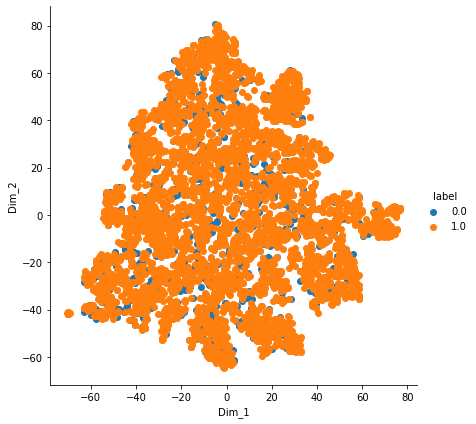

In [67]:
import seaborn as sn
import matplotlib.pyplot as plt 
tsne_data = np.vstack((tsne_emb.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

In [68]:

model =TSNE(n_components=2, random_state=0, n_iter=5000)
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_emb =model.fit_transform(std_avg_w2v)
tsne_emb.shape

(4986, 2)

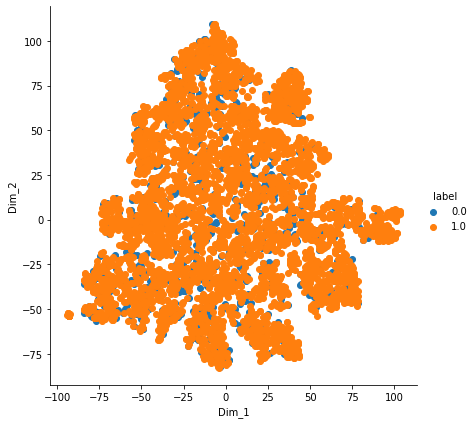

In [69]:

tsne_data = np.vstack((tsne_emb.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

The 0 labelled reviews and 1 labelled reviews are not separable after dimension reduction by TSNE.The ouput didn't change on multiple runs or when increasing n_iter. 

In [70]:
model =TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_emb =model.fit_transform(std_avg_w2v)
tsne_emb.shape

(4986, 2)

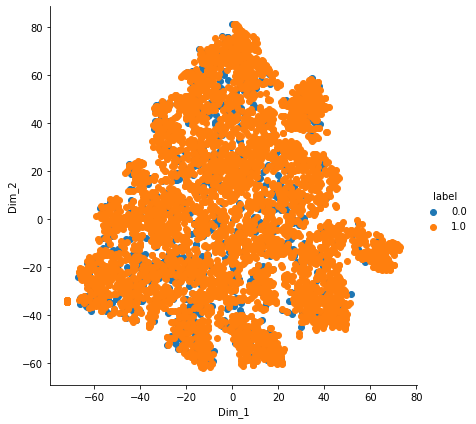

In [71]:

tsne_data = np.vstack((tsne_emb.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

Change  in perplexity didn't help much 

##### TSNE on tfidf w2v

In [72]:
std_tfidf_w2v=StandardScaler().fit_transform(tfidf_w2v)
std_tfidf_w2v.shape

(4986, 50)

In [73]:
model =TSNE(n_components=2, random_state=0)
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_emb =model.fit_transform(std_tfidf_w2v)
tsne_emb.shape

(4986, 2)

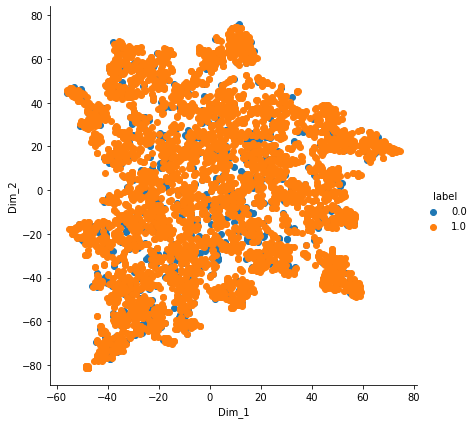

In [74]:
tsne_data = np.vstack((tsne_emb.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

In [75]:
model =TSNE(n_components=2, random_state=0, n_iter=5000 )
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_emb =model.fit_transform(std_tfidf_w2v)
tsne_emb.shape

(4986, 2)

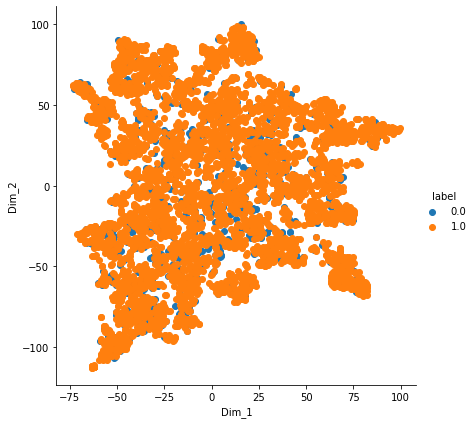

In [76]:
tsne_data = np.vstack((tsne_emb.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

The output wasn't separable on two categories for tfidf word2vec too.

So, now we use Googles's w2v to embed the words for accurate results.

# Use Google's W2V 

In [ ]:
from gensim.models import KeyedVectors
want_to_use_google_w2v=True 
is_your_ram_gt_16g=True #make it true to load google's w2v model 
#download and extract GoogleNews-vectors-negative300.bin from:
#https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

if want_to_use_google_w2v and is_your_ram_gt_16g:
    w2v_model=KeyedVectors.load_word2vec_format('../Data/GoogleNews-vectors-negative300.bin', binary=True)
    
    

In [ ]:
w2v_words = list(w2v_model.wv.vocab)


In [ ]:
tfidf_w2v =[]
for sentence in  tqdm(list_of_sentence):
    emb_vec = np.zeros(300) #the vectors of Google news are 300 dim-vectors
    sum_tfidf=0
    for word in sentence:
        if word in w2v_words and word in words_tf_weight:
            vec= w2v_model.wv[word]
            tf_idf = words_tf_weight[word]*(sentence.count(word)/len(sentence))
            emb_vec += tf_idf*vec
            sum_tfidf += tf_idf
    
    if (sum_tfidf!=0): emb_vec/=sum_tfidf
    tfidf_w2v.append(emb_vec)


In [86]:
std_tfidf_w2v=StandardScaler().fit_transform(tfidf_w2v)
std_tfidf_w2v.shape

(4986, 300)

In [87]:
model =TSNE(n_components=2, random_state=0)
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_emb =model.fit_transform(std_tfidf_w2v)
tsne_emb.shape

(4986, 2)

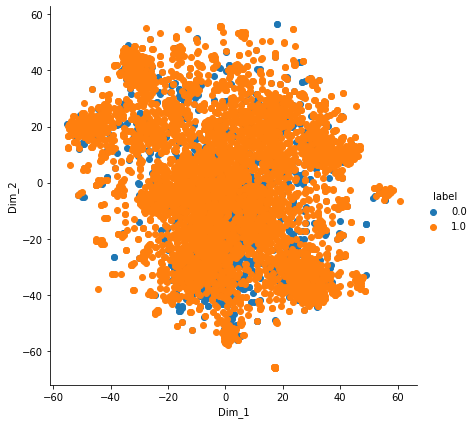

In [88]:
tsne_data = np.vstack((tsne_emb.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

The category is not separable even with the use of embeddings provided by Google w2v.